### Лабораторная работа №5
#### Идентификация параметров линейного регрессионного объекта при α− загрязненных шумах

Пусть линейный регрессионный объект имеет вид:
$$ \large y(i)=с_{0}+с_{1}u_{1}(i)+...+с_{4}u_{4}(i)+\eta(i) , $$ 

где шум, действующий на объект, принадлежит классу приближенно нормальных распределений:
$ \large f(\eta) = (1-\alpha)f_N(\eta) + \alpha g(\eta) $ <br>
$ \large f_N(\eta) = \frac{1}{\sqrt{2 \pi} \sigma_\eta} exp(- \frac{\eta^2}{2 \sigma^2_\eta}) $ - нормальное распределение $ \large N(0, \sigma_\eta)$, <br>
$\large \alpha$ - вероятность появление выброса с рапределением $\large g(\eta)$ <br>
$\large g(\eta)$ - вообще говоря какое-то распределение, но в данной лабораторной работе будет нормальным $ \large N(0, \sigma_\eta (outlier))$, но его параметры отличны от $\large f_N(\eta)$

In [1]:
# параметры объекта 
с0=5
с1=2
с2=10
с3=17
с4=14

In [2]:
# количество измерений
N=200
Count_measur=N

#### Сгенерируем шум, принадлежащий классу приближенно нормальных распределений

In [3]:
import numpy as np
from scipy.stats import rv_continuous

In [4]:
# класс для "загрязненного" распределения
class gaussian_gen(rv_continuous):
    
    def _pdf(self, x, alpha, sigma_1, sigma_2):
        "Gaussian distribution"
        def gaussian(self, x, sigma):
            return np.exp(-x**2 / 2. / sigma**2) / (np.sqrt(2.0 * np.pi)*sigma)
        
        return (1-alpha)*gaussian(self, x, sigma_1)+alpha*gaussian(self, x, sigma_2)

gaussian = gaussian_gen(name='dirty_distrib')

Зададим следующие параметры нашего загрязненного распределения для шума:

In [5]:
alpha = 0.1
sigma_1 = 0.5
sigma_2 = 50
Noise = gaussian.rvs(alpha, sigma_1, sigma_2, size=N)

#### Посмотрим на сгенерированный шум и увидим "выбросы" из другого распределения

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

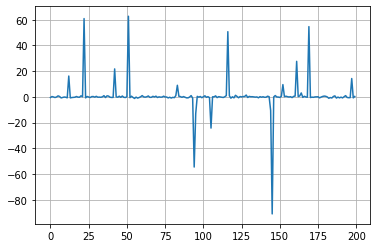

In [7]:
plt.plot(Noise)
plt.grid()

#### Зададим параметры входов объекта и смоделируем выход объекта

In [8]:
#Ваш код здесь
var=50

Avg_U1=1
Var_U1=var
Avg_U2=2
Var_U2=var
Avg_U3=3
Var_U3=var
Avg_U4=4
Var_U4=var

In [9]:
#Ваш код здесь
U1=np.random.normal(Avg_U1, Var_U1, N)
U2=np.random.normal(Avg_U2, Var_U2, N)
U3=np.random.normal(Avg_U3, Var_U3, N)
U4=np.random.normal(Avg_U4, Var_U4, N)
U0=[1]*N
X = np.vstack((U0,U1,U2,U3,U4))

In [10]:
# моделирование выхода объекта
y=с0+с1*U1+с2*U2+с3*U3+с4*U4+Noise

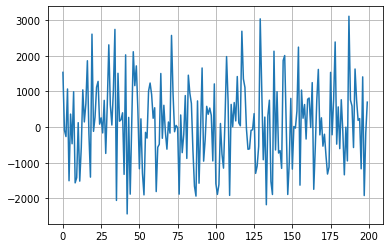

In [11]:
plt.plot(y)
plt.grid()

In [12]:
from sympy import *
init_printing(use_unicode=False, wrap_line=False)
# алгоритм Хубера

class Huber():
    N=Count_measur
    def __init__(self,lamda,ksi):
        self.lamda=lamda
        self.ksi=ksi
        self.c_estim_huber=[]
        self.delta=ksi*sigma_1
    
    def _fN(self,x,sigma):
        res = exp(-x**2/(2*sigma**2))/(sigma*sqrt(2*pi))
        return res.n()

    def _FisherIntegrate(self,delta,sigma):
        x = Symbol('x')
        res=integrate(x*x*exp(-x**2/(2*sigma*sigma)), (x,-delta,delta))
        return res.n()
    
    def _If(self,alpha,delta,sigma):
        res=2*(1-alpha)*(delta/sigma**2)*self._fN(delta/sigma,sigma)+(1-alpha)*(1/(sqrt(2*pi)*sigma**5))*self._FisherIntegrate(delta,sigma)
        return res.n()
    
    def _Gam(self,G_0,i):
        z=np.vstack((self.X[0][i],self.X[1][i],self.X[2][i],self.X[3][i],self.X[4][i]))
        res=G_0-(G_0.dot(z).dot(z.T).dot(G_0))/(1/self.Ifish+z.T.dot(G_0).dot(z))
        return res

    def _C(self,G,c_0,i):
        z=np.vstack((self.X[0][i],self.X[1][i],self.X[2][i],self.X[3][i],self.X[4][i]))
        y_cur=z.T.dot(c_0)
        epsilon=self.y[i]-y_cur
        if epsilon<=-self.delta:
            d=-self.delta
        elif epsilon>=self.delta:
            d=self.delta
        
        else:
            d=epsilon
            
        res=c_0+d*G.dot(z)
        return res
    
    def fit(self,X, y, c0):
        self.X=X
        self.y=y
        I=np.eye(5)
        G=self.lamda*I
        self.Ifish=self._If(alpha,self.delta,sigma_1)
        for i in range(1,self.N):
            self.c_estim_huber.append(c0)
            G=self._Gam(G,i)
            c0=self._C(G,c0,i)
        self.c_estim_huber.append(c0)
    
    def get_coefs(self):
        return self.c_estim_huber
    

In [13]:
# Рекуррентный МНК
class RecurrentMLS():
    N=Count_measur
    def __init__(self,lamda):
        self.lamda=lamda
        self.c_estim_recMLS=[]
    
    def _C(self,K,c_0,i):
        z=np.vstack((self.X[0][i],self.X[1][i],self.X[2][i],self.X[3][i],self.X[4][i]))
        y_cur=z.T.dot(c_0)
        return c_0+K*(self.y[i]-y_cur)
    
    def _K(self,H,i):
        z=np.vstack((self.X[0][i],self.X[1][i],self.X[2][i],self.X[3][i],self.X[4][i]))
        return H.dot(z)
    
    def _H(self,H_0,i):
        z=np.vstack((self.X[0][i],self.X[1][i],self.X[2][i],self.X[3][i],self.X[4][i]))
        return H_0-1/(1+z.T.dot(H_0).dot(z))*H_0.dot(z).dot(z.T).dot(H_0)
        
    
    def fit(self,X, y, c0):
        self.X=X
        self.y=y
        I=np.eye(5)
        H=self.lamda*I
        
        for i in range(1,self.N):
            self.c_estim_recMLS.append(c0)
            H=self._H(H,i)
            K=self._K(H,i)
            c0=self._C(K,c0,i)
        self.c_estim_recMLS.append(c0)
            
    def get_coefs(self):
        return self.c_estim_recMLS
    


In [14]:
def smooth_errors(c_estim,c_true):
    N=Count_measur
    i=10
    err=[]
    while i<N:
        cur_sum=0
        for j in range(10):
            for k in range(4):
                cur_sum+=(c_estim[i-j][k]-c_true[k])**2
        cur_sum=pow(cur_sum/10,0.5)
        err.append(cur_sum)
        i=i+1
    return err


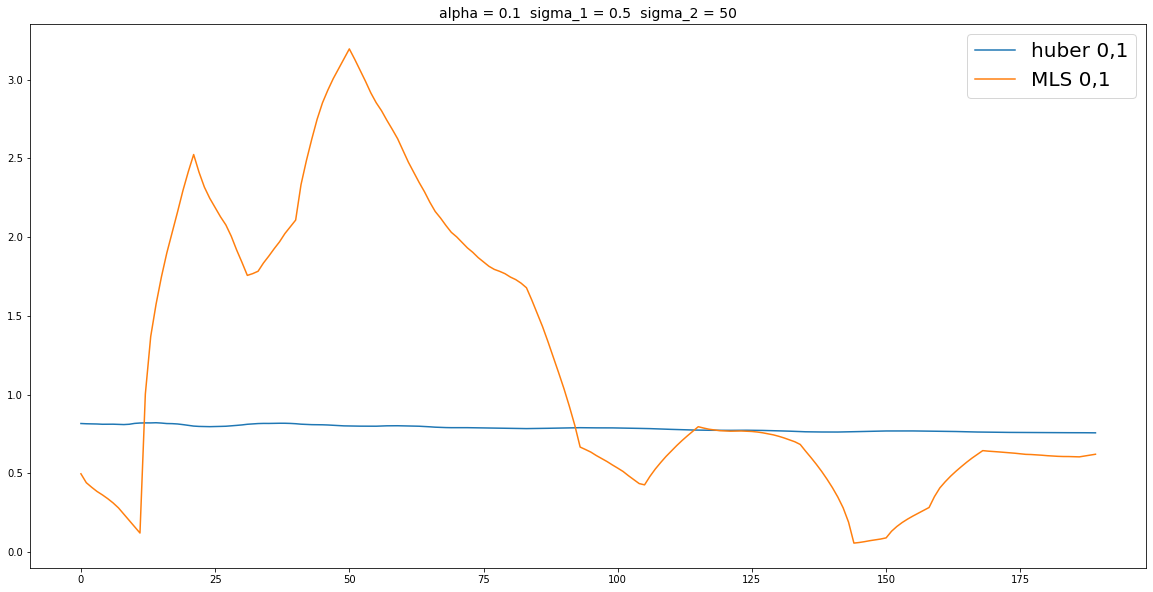

In [15]:
c0=np.vstack((4.5,2.5,10.3,16.7,13.9))
c01=np.vstack((4.5,2.5,10.3,16.7,13.9))
X01=X
y01=y

h=Huber(0.1,1.1)
h.fit(X,y,c0)
C_res=h.get_coefs()

mn=RecurrentMLS(0.1)
mn.fit(X01,y01,c01)
C_res2=mn.get_coefs()


c_real=np.array([5,2,10,17,14])
err1=smooth_errors(C_res,c_real)
err2=smooth_errors(C_res2,c_real)

plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(err1,label='huber 0,1')
plt.plot(err2,label='MLS 0,1')

plt.legend(fontsize = 20)
plt.title('alpha = '+str(alpha)+'  sigma_1 = '+str(sigma_1)+'  sigma_2 = '+str(sigma_2),fontsize=14)
plt.show()


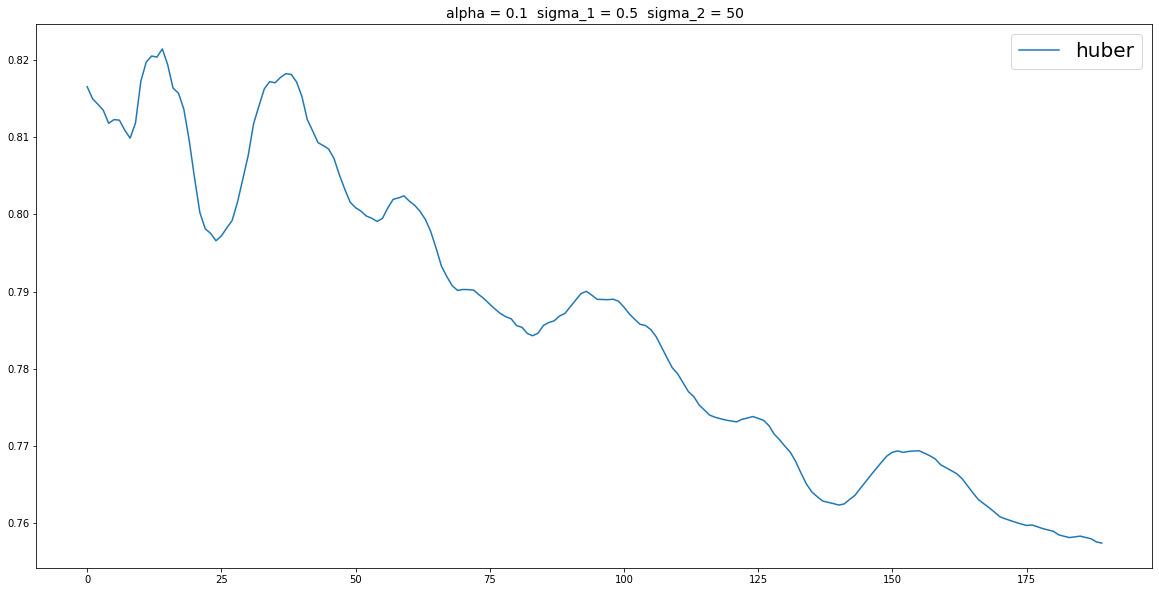

In [16]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(err1,label='huber')
plt.legend(fontsize = 20);
plt.title('alpha = '+str(alpha)+'  sigma_1 = '+str(sigma_1)+'  sigma_2 = '+str(sigma_2),fontsize=14)
plt.show()

### Эффективность алгоритма Хубера vs Рекуррентным МНК при различных статистических характеристиках распределений

В лабораторной работе требуется:

1. Реализовать __class Huber__ c методами: <br>
   * в конструкторе класса небходимо задать:<br>
     1) λ в формуле задания начального приближения матрицы Г(0) = λ*I <br>
    2) параметр $ \xi $, участвующий в функции потерь Хьюбера, в зависимости от вероятности появления выброса $ \alpha $ (значения которого приведены в описании ЛР) <br><br>
   *   __def fit(X, y, c0)__ - метод реализует алгоритм итерационного оценивания параметов объекта с использованием функции потерь Хьюбера:<br>
        <br>
        Input:<br>
            X - матрица входов объекта, [X] = m x N <br>
            y - вектор выходов объекта, [y] = N <br>
            с0 - вектор начального приближения, [c0] = m <br>
        <br>       
   * __def get_coefs()__ - метод возвращает массив коэффициентов оценок вектора параметров объекта, получаемого на каждом новом шаге измерений<br>
        <br>
        Output:<br>
            c_estim_huber - массив оценок параметров объекта, полученный в результате работы метода fit<br><br>
2. Реализовать __class RecurrentMLS__ с методами: <br>

    * в конструкторе класса небходимо задать:<br>
     1) λ в формуле задания начального приближения матрицы Г(0) = λ*I <br><br>

    * __def fit(X, y, c0)__ - метод реализует алгоритм итерационного оценивания параметов объекта с использованием квадратичной функции потерь (см. 2 лабораторную работу):<br>
         <br>
     Input:<br>
             X - матрица входов объекта, [X] = m x N<br>
             y - вектор выходов объекта, [y] = N<br>
             с0 - вектор начального приближения, [c0] = m+1<br><br>
        
    * __def get_coefs()__ - метод возвращает массив коэффициентов оценок вектора параметров объекта, получаемого на каждом новом шаге измерений<br>
        <br>
        Output:<br>
            c_estim_recMLS - массив оценок параметров объекта, полученный в результате работы метода fit<br><br>        
3. Реализовать функцию __smooth_errors(c_estim, c_true)__  - вычисляет сглаженную ошибку оценки по 10 измерениям. <br>
         Input: 
             c_estim - массив оценок параметров объекта, [c_estim] = m+1 x N
             c_true - вектор истинных параметров объекта, [c_true] = m+1 
         Output:
             err - массив сглаженных ошибок оценки
              
4. Провести исследование эффективности алгоритма Хубера по сравнению с рекуррентным МНК алгоритмом при следующих статистических характеристиках распределений:<br>
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 10;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 50;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 100;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 10;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 50;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 100. <br><br>
5. Построить графики сходимости сглаженной ошибки оценки по двум алгоритмам: алгоритм с использованием теоремы Хубера и рекуррентный алгоритм, соответствующий методу наименьших квадратов. Сдалать выводы.

### Hints

1. Рекуррентный алгоритм при функции потерь Хьюбера имеет вид:
\begin{equation} \large \hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)d(\varepsilon(i, \hat{\vec{c}}(i-1)))\vec{z}(i) \\
\large Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{I^{-1}_F+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
\large Г(0)=\lambda I, \lambda >> 1,  \hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

где $ \large  \Delta = \xi\sigma_\eta$
\begin{equation} \large d(\varepsilon(i, \hat{\vec{c}}(i-1)))=\frac{dF(\varepsilon(i, \hat{\vec{c}}(i-1)))}{d\varepsilon}|_{\varepsilon = \varepsilon(i, \hat{\vec{c}}(i-1)))}= \left\{
    \begin{array}\\
        -\Delta, & \varepsilon(i) \leq -\Delta \\
        \varepsilon(i, \hat{\vec{c}}(i-1))), & -\Delta \leq |\varepsilon(i)| \leq \Delta\\
        \Delta, &  \varepsilon(i) \geq \Delta
    \end{array}  
\right.\end{equation}

\begin{equation} \large  I_F=2(1-\alpha)\frac{\Delta}{\sigma^2_\eta}f_N(\frac{\Delta}{\sigma_\eta})+(1-\alpha)\frac{1}{\sqrt{2\pi}\sigma_\eta}\frac{1}{\sigma^4_\eta}\int_{-\Delta}^\Delta \eta^2exp(\frac{-\eta^2}{2\sigma^2_\eta})d\eta\end{equation}

2. Для вычислении информации Фишера можно использовать модуль __sympy__ (https://docs.sympy.org/latest/modules/integrals/integrals.html)